# Лабораторная работа №2: Исследование логистической и линейной регрессии

**Цель:** Провести полное исследование алгоритмов логистической и линейной регрессии на датасете диабета, включая задачи классификации и регрессии.

**Датасет:** diabetes_dataset.csv (100,000 записей, 31 признак)
- **Классификация:** предсказание наличия диабета (diagnosed_diabetes: 0/1)
- **Регрессия:** предсказание возраста пациентов (age)

**Метрики качества:**
- Классификация: Accuracy, Precision, Recall, F1-score
- Регрессия: MSE (Mean Squared Error)


## 1. Импорт библиотек и загрузка данных

Импортируем необходимые библиотеки для анализа данных, машинного обучения и визуализации.


In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


Загружаем датасет и проводим первичный анализ структуры данных.


In [64]:
df = pd.read_csv('diabetes_dataset.csv')
print(f"Размер датасета: {df.shape}")
print(f"\nКоличество пропущенных значений: {df.isnull().sum().sum()}")
print(f"\nТипы данных:")
print(df.dtypes.value_counts())

print(f"\nЦелевые переменные:")
print(f"Классификация (diagnosed_diabetes): {df['diagnosed_diabetes'].value_counts().to_dict()}")
print(f"Регрессия (age): min={df['age'].min()}, max={df['age'].max()}, mean={df['age'].mean():.1f}")


Размер датасета: (100000, 31)

Количество пропущенных значений: 0

Типы данных:
int64      16
float64     8
object      7
Name: count, dtype: int64

Целевые переменные:
Классификация (diagnosed_diabetes): {1: 59998, 0: 40002}
Регрессия (age): min=18, max=90, mean=50.1


## 2. Выбор начальных условий и обоснование

### 2.1 Обоснование выбора датасета

**Датасет для классификации:** diabetes_dataset.csv
- **Размер:** 100,000 записей обеспечивает достаточную статистическую мощность
- **Признаки:** 30 признаков включают демографические, медицинские и поведенческие факторы
- **Целевая переменная:** diagnosed_diabetes (бинарная классификация)

**Датасет для регрессии:** тот же diabetes_dataset.csv
- **Целевая переменная:** age (непрерывная переменная от 18 до 100 лет)


### 2.2 Обоснование выбора метрик качества

**Для классификации:**
- **Accuracy:** общая точность классификации
- **Precision:** доля правильно предсказанных случаев диабета среди всех предсказанных
- **Recall:** доля правильно предсказанных случаев диабета среди всех реальных случаев
- **F1-score:** гармоническое среднее precision и recall

**Для регрессии:**
- **MSE (Mean Squared Error):** показывает среднее квадратичное отклонение предсказаний от реальных значений возраста


### 2.3 Подготовка данных для анализа

Выделяем признаки и целевые переменные, проводим кодирование категориальных переменных.


In [65]:
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_features = [col for col in numeric_features if col not in ['diagnosed_diabetes', 'diabetes_risk_score']]

categorical_features = df.select_dtypes(include=['object']).columns.tolist()

print(f"Числовые признаки ({len(numeric_features)}): {numeric_features}")
print(f"\nКатегориальные признаки ({len(categorical_features)}): {categorical_features}")

df_encoded = df.copy()
le = LabelEncoder()

for col in categorical_features:
    df_encoded[col] = le.fit_transform(df[col])

print(f"\nПосле кодирования размер датасета: {df_encoded.shape}")


Числовые признаки (22): ['age', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week', 'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day', 'family_history_diabetes', 'hypertension_history', 'cardiovascular_history', 'bmi', 'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate', 'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides', 'glucose_fasting', 'glucose_postprandial', 'insulin_level', 'hba1c']

Категориальные признаки (7): ['gender', 'ethnicity', 'education_level', 'income_level', 'employment_status', 'smoking_status', 'diabetes_stage']

После кодирования размер датасета: (100000, 31)


### 2.4 Разделение данных на обучающую и тестовую выборки

Разделяем данные на обучающую (70%) и тестовую (30%) выборки для обеих задач.


In [66]:
X_class = df_encoded.drop(['diagnosed_diabetes', 'diabetes_stage', 'diabetes_risk_score'], axis=1)
y_class = df_encoded['diagnosed_diabetes']

X_reg = df_encoded.drop(['age', 'diagnosed_diabetes', 'diabetes_stage', 'diabetes_risk_score'], axis=1)
y_reg = df_encoded['age']


X_class_train, X_class_test, y_class_train, y_class_test = train_test_split(
    X_class, y_class, test_size=0.3, random_state=42, stratify=y_class
)


X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
    X_reg, y_reg, test_size=0.3, random_state=42
)

print(f"Классификация - Обучающая выборка: {X_class_train.shape}, Тестовая: {X_class_test.shape}")
print(f"Регрессия - Обучающая выборка: {X_reg_train.shape}, Тестовая: {X_reg_test.shape}")
print(f"\nРаспределение классов в тестовой выборке (классификация): {y_class_test.value_counts().to_dict()}")


Классификация - Обучающая выборка: (70000, 28), Тестовая: (30000, 28)
Регрессия - Обучающая выборка: (70000, 27), Тестовая: (30000, 27)

Распределение классов в тестовой выборке (классификация): {1: 17999, 0: 12001}


## 3. Создание бейзлайна и оценка качества

### 3.1 Бейзлайн для классификации

Обучаем логистический регрессор с параметрами по умолчанию и оцениваем качество.


In [67]:
lr_class_baseline = LogisticRegression(random_state=42, max_iter=1000)
lr_class_baseline.fit(X_class_train, y_class_train)

y_class_pred_baseline = lr_class_baseline.predict(X_class_test)

accuracy_baseline = accuracy_score(y_class_test, y_class_pred_baseline)
precision_baseline = precision_score(y_class_test, y_class_pred_baseline)
recall_baseline = recall_score(y_class_test, y_class_pred_baseline)
f1_baseline = f1_score(y_class_test, y_class_pred_baseline)

print(f"Accuracy: {accuracy_baseline:.4f}")
print(f"Precision: {precision_baseline:.4f}")
print(f"Recall: {recall_baseline:.4f}")
print(f"F1-score: {f1_baseline:.4f}")

print("\nОтчет по классификации:")
print(classification_report(y_class_test, y_class_pred_baseline))


Accuracy: 0.8327
Precision: 0.8464
Recall: 0.8810
F1-score: 0.8633

Отчет по классификации:
              precision    recall  f1-score   support

           0       0.81      0.76      0.78     12001
           1       0.85      0.88      0.86     17999

    accuracy                           0.83     30000
   macro avg       0.83      0.82      0.82     30000
weighted avg       0.83      0.83      0.83     30000



### 3.2 Бейзлайн для регрессии

Обучаем линейный регрессор с параметрами по умолчанию и оцениваем качество.


In [68]:
lr_reg_baseline = LinearRegression()
lr_reg_baseline.fit(X_reg_train, y_reg_train)

y_reg_pred_baseline = lr_reg_baseline.predict(X_reg_test)

mse_baseline = mean_squared_error(y_reg_test, y_reg_pred_baseline)

print(f"MSE: {mse_baseline:.4f}")
print(f"RMSE: {np.sqrt(mse_baseline):.4f}")
print(f"\nСтатистика предсказаний:")
print(f"Среднее предсказание: {y_reg_pred_baseline.mean():.2f}")
print(f"Среднее реальное значение: {y_reg_test.mean():.2f}")
print(f"Стандартное отклонение предсказаний: {y_reg_pred_baseline.std():.2f}")
print(f"Стандартное отклонение реальных значений: {y_reg_test.std():.2f}")


MSE: 146.2096
RMSE: 12.0917

Статистика предсказаний:
Среднее предсказание: 50.12
Среднее реальное значение: 49.93
Стандартное отклонение предсказаний: 9.91
Стандартное отклонение реальных значений: 15.63


## 4. Улучшение бейзлайна

### 4.1 Гипотезы для улучшения

1. Масштабирование признаков: регрессия чувствительна к масштабу признаков
2. Регуляризация: предотвращение переобучения через L1/L2 регуляризацию
3. Подбор гиперпараметров: выбор оптимального C для логистической регрессии и alpha для линейной регрессии
4. Солоушинг: использование разных солверов для оптимизации
5. Отбор признаков: удаление менее важных признаков


### 4.2 Масштабирование признаков

Применяем StandardScaler для нормализации признаков.


In [69]:
scaler = StandardScaler()
X_class_train_scaled = scaler.fit_transform(X_class_train)
X_class_test_scaled = scaler.transform(X_class_test)


X_reg_train_scaled = scaler.fit_transform(X_reg_train)
X_reg_test_scaled = scaler.transform(X_reg_test)

print("Масштабирование применено успешно")
print(f"Среднее значение признаков после масштабирования (классификация): {X_class_train_scaled.mean(axis=0)[:5]}")
print(f"Стандартное отклонение признаков после масштабирования (классификация): {X_class_train_scaled.std(axis=0)[:5]}")


Масштабирование применено успешно
Среднее значение признаков после масштабирования (классификация): [-6.88211393e-17 -4.32416008e-17 -4.01964176e-17 -4.81138938e-17
 -9.50097144e-17]
Стандартное отклонение признаков после масштабирования (классификация): [1. 1. 1. 1. 1.]


### 4.3 Подбор гиперпараметров

Используем GridSearchCV для поиска оптимальных параметров регуляризации и солвера.


In [70]:
param_grid_class = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

grid_search_class = GridSearchCV(
    LogisticRegression(random_state=42, max_iter=1000),
    param_grid=param_grid_class,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_search_class.fit(X_class_train_scaled, y_class_train)

param_grid_class_l2 = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['lbfgs']
}

grid_search_class_l2 = GridSearchCV(
    LogisticRegression(random_state=42, max_iter=1000),
    param_grid=param_grid_class_l2,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_search_class_l2.fit(X_class_train_scaled, y_class_train)

if grid_search_class.best_score_ >= grid_search_class_l2.best_score_:
    grid_search_class = grid_search_class
else:
    grid_search_class = grid_search_class_l2

print("Лучшие параметры для классификации:")
print(grid_search_class.best_params_)
print(f"Лучший F1-score на кросс-валидации: {grid_search_class.best_score_:.4f}")


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Лучшие параметры для классификации:
{'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Лучший F1-score на кросс-валидации: 0.8843


Для линейной регрессии используем Ridge и Lasso регуляризацию для подбора гиперпараметров.


In [71]:
from sklearn.linear_model import Ridge, Lasso

param_grid_reg = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100]
}

grid_search_reg = GridSearchCV(
    Ridge(),
    param_grid_reg,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search_reg.fit(X_reg_train_scaled, y_reg_train)

print("Лучшие параметры для регрессии (Ridge):")
print(grid_search_reg.best_params_)
print(f"Лучший MSE на кросс-валидации: {-grid_search_reg.best_score_:.4f}")


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Лучшие параметры для регрессии (Ridge):
{'alpha': 10}
Лучший MSE на кросс-валидации: 144.2559


### 4.4 Оценка улучшенных моделей

Обучаем модели с лучшими параметрами и сравниваем с бейзлайном.


In [72]:
lr_class_improved = grid_search_class.best_estimator_
y_class_pred_improved = lr_class_improved.predict(X_class_test_scaled)

accuracy_improved = accuracy_score(y_class_test, y_class_pred_improved)
precision_improved = precision_score(y_class_test, y_class_pred_improved)
recall_improved = recall_score(y_class_test, y_class_pred_improved)
f1_improved = f1_score(y_class_test, y_class_pred_improved)

print(f"Accuracy: {accuracy_improved:.4f} (было: {accuracy_baseline:.4f})")
print(f"Precision: {precision_improved:.4f} (было: {precision_baseline:.4f})")
print(f"Recall: {recall_improved:.4f} (было: {recall_baseline:.4f})")
print(f"F1-score: {f1_improved:.4f} (было: {f1_baseline:.4f})")

print("\nСравнение с бейзлайном:")
print(f"Улучшение Accuracy: {((accuracy_improved - accuracy_baseline) / accuracy_baseline * 100):.2f}%")
print(f"Улучшение F1-score: {((f1_improved - f1_baseline) / f1_baseline * 100):.2f}%")


Accuracy: 0.8596 (было: 0.8327)
Precision: 0.8749 (было: 0.8464)
Recall: 0.8937 (было: 0.8810)
F1-score: 0.8842 (было: 0.8633)

Сравнение с бейзлайном:
Улучшение Accuracy: 3.23%
Улучшение F1-score: 2.42%


In [73]:
lr_reg_improved = grid_search_reg.best_estimator_
y_reg_pred_improved = lr_reg_improved.predict(X_reg_test_scaled)

mse_improved = mean_squared_error(y_reg_test, y_reg_pred_improved)

print(f"MSE: {mse_improved:.4f} (было: {mse_baseline:.4f})")
print(f"RMSE: {np.sqrt(mse_improved):.4f} (было: {np.sqrt(mse_baseline):.4f})")

print("\nСравнение с бейзлайном:")
print(f"Улучшение MSE: {((mse_baseline - mse_improved) / mse_baseline * 100):.2f}%")
print(f"Улучшение RMSE: {((np.sqrt(mse_baseline) - np.sqrt(mse_improved)) / np.sqrt(mse_baseline) * 100):.2f}%")


MSE: 146.2094 (было: 146.2096)
RMSE: 12.0917 (было: 12.0917)

Сравнение с бейзлайном:
Улучшение MSE: 0.00%
Улучшение RMSE: 0.00%


## 5. Имплементация алгоритмов с нуля

### 5.1 Реализация логистической регрессии

Создаем собственную реализацию логистической регрессии с использованием градиентного спуска.


In [74]:
class CustomLogisticRegression:
    def __init__(self, learning_rate=0.01, max_iter=1000, C=1.0, penalty='l2', random_state=42):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.C = C
        self.penalty = penalty
        self.random_state = random_state
        self.weights = None
        self.bias = None
        
    def _sigmoid(self, z):
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))
    
    def fit(self, X, y):
        np.random.seed(self.random_state)
        X = np.array(X, dtype=float)
        y = np.array(y, dtype=int)
        
        n_features = X.shape[1]
        self.weights = np.random.randn(n_features) * 0.01
        self.bias = 0.0
        
        n_samples = X.shape[0]
        
        for iteration in range(self.max_iter):
            linear_model = np.dot(X, self.weights) + self.bias
            y_pred = self._sigmoid(linear_model)
            
            dw = (1 / n_samples) * np.dot(X.T, (y_pred - y))
            db = (1 / n_samples) * np.sum(y_pred - y)
            
            if self.penalty == 'l2':
                dw += (1 / self.C) * self.weights
            elif self.penalty == 'l1':
                dw += (1 / self.C) * np.sign(self.weights)
            
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
        
        return self
    
    def predict_proba(self, X):
        X = np.array(X, dtype=float)
        linear_model = np.dot(X, self.weights) + self.bias
        return self._sigmoid(linear_model)
    
    def predict(self, X):
        proba = self.predict_proba(X)
        return (proba >= 0.5).astype(int)


### 5.2 Реализация линейной регрессии

Создаем собственную реализацию линейной регрессии с использованием градиентного спуска или нормального уравнения.


In [75]:
class CustomLinearRegression:
    def __init__(self, fit_intercept=True, alpha=0.0, penalty='l2'):
        self.fit_intercept = fit_intercept
        self.alpha = alpha
        self.penalty = penalty
        self.coef_ = None
        self.intercept_ = None
        
    def fit(self, X, y, use_normal_equation=True):
        X = np.array(X, dtype=float)
        y = np.array(y, dtype=float).reshape(-1, 1)
        
        if self.fit_intercept:
            X = np.column_stack([np.ones(X.shape[0]), X])
        
        if use_normal_equation:
            if self.alpha == 0:
                try:
                    self.coef_ = np.linalg.solve(X.T @ X, X.T @ y).flatten()
                except np.linalg.LinAlgError:
                    self.coef_ = np.linalg.pinv(X.T @ X) @ X.T @ y
                    self.coef_ = self.coef_.flatten()
            elif self.penalty == 'l2':
                n_features = X.shape[1]
                identity = np.eye(n_features)
                if self.fit_intercept:
                    identity[0, 0] = 0
                try:
                    self.coef_ = np.linalg.solve(X.T @ X + self.alpha * identity, X.T @ y).flatten()
                except np.linalg.LinAlgError:
                    self.coef_ = np.linalg.pinv(X.T @ X + self.alpha * identity) @ X.T @ y
                    self.coef_ = self.coef_.flatten()
            else:
                n_samples, n_features = X.shape
                self.coef_ = np.random.randn(n_features) * 0.01
                learning_rate = 0.01
                max_iter = 1000
                
                for _ in range(max_iter):
                    y_pred = X @ self.coef_.reshape(-1, 1)
                    error = y_pred - y
                    
                    dw = (1 / n_samples) * (X.T @ error).flatten()
                    
                    if self.penalty == 'l1':
                        dw += self.alpha * np.sign(self.coef_)
                    
                    self.coef_ -= learning_rate * dw
        else:
            n_samples, n_features = X.shape
            self.coef_ = np.random.randn(n_features) * 0.01
            
            learning_rate = 0.01
            max_iter = 1000
            
            for _ in range(max_iter):
                y_pred = X @ self.coef_.reshape(-1, 1)
                error = y_pred - y
                
                dw = (1 / n_samples) * (X.T @ error).flatten()
                
                if self.penalty == 'l2':
                    dw += self.alpha * self.coef_
                elif self.penalty == 'l1':
                    dw += self.alpha * np.sign(self.coef_)
                
                self.coef_ -= learning_rate * dw
        
        if self.fit_intercept:
            self.intercept_ = self.coef_[0]
            self.coef_ = self.coef_[1:]
        else:
            self.intercept_ = 0.0
        
        return self
    
    def predict(self, X):
        X = np.array(X, dtype=float)
        return (X @ self.coef_ + self.intercept_).flatten()


### 5.3 Обучение и оценка собственных реализаций

Обучаем собственные реализации логистической и линейной регрессии и сравниваем с sklearn версиями.


In [76]:
custom_lr_class_baseline = CustomLogisticRegression(C=1.0, penalty='l2', max_iter=1000, learning_rate=0.01)
custom_lr_class_baseline.fit(X_class_train, y_class_train)
y_class_pred_custom_baseline = custom_lr_class_baseline.predict(X_class_test)

accuracy_custom_baseline = accuracy_score(y_class_test, y_class_pred_custom_baseline)
precision_custom_baseline = precision_score(y_class_test, y_class_pred_custom_baseline)
recall_custom_baseline = recall_score(y_class_test, y_class_pred_custom_baseline)
f1_custom_baseline = f1_score(y_class_test, y_class_pred_custom_baseline)

print("Результаты базовой собственной реализации логистической регрессии для классификации:")
print(f"Accuracy: {accuracy_custom_baseline:.4f}")
print(f"Precision: {precision_custom_baseline:.4f}")
print(f"Recall: {recall_custom_baseline:.4f}")
print(f"F1-score: {f1_custom_baseline:.4f}")

print("\nСравнение с sklearn бейзлайном:")
print(f"Разница в Accuracy: {abs(accuracy_custom_baseline - accuracy_baseline):.6f}")
print(f"Разница в F1-score: {abs(f1_custom_baseline - f1_baseline):.6f}")


Результаты базовой собственной реализации логистической регрессии для классификации:
Accuracy: 0.6912
Precision: 0.9355
Recall: 0.5212
F1-score: 0.6694

Сравнение с sklearn бейзлайном:
Разница в Accuracy: 0.141500
Разница в F1-score: 0.193916


In [77]:
custom_lr_reg_baseline = CustomLinearRegression(fit_intercept=True, alpha=0.0)
custom_lr_reg_baseline.fit(X_reg_train, y_reg_train)
y_reg_pred_custom_baseline = custom_lr_reg_baseline.predict(X_reg_test)

mse_custom_baseline = mean_squared_error(y_reg_test, y_reg_pred_custom_baseline)

print("Результаты базовой собственной реализации линейной регрессии для регрессии:")
print(f"MSE: {mse_custom_baseline:.4f}")
print(f"RMSE: {np.sqrt(mse_custom_baseline):.4f}")

print("\nСравнение с sklearn бейзлайном:")
print(f"Разница в MSE: {abs(mse_custom_baseline - mse_baseline):.6f}")
print(f"Разница в RMSE: {abs(np.sqrt(mse_custom_baseline) - np.sqrt(mse_baseline)):.6f}")


Результаты базовой собственной реализации линейной регрессии для регрессии:
MSE: 146.2096
RMSE: 12.0917

Сравнение с sklearn бейзлайном:
Разница в MSE: 0.000000
Разница в RMSE: 0.000000


### 5.4 Применение техник улучшения к собственным реализациям

Проверяем, что собственные реализации работают с теми же техниками улучшения.


In [78]:
best_params_class = grid_search_class.best_params_
custom_lr_class_improved = CustomLogisticRegression(
    C=best_params_class['C'],
    penalty=best_params_class['penalty'],
    max_iter=1000,
    learning_rate=0.01
)

custom_lr_class_improved.fit(X_class_train_scaled, y_class_train)
y_class_pred_custom_improved = custom_lr_class_improved.predict(X_class_test_scaled)

accuracy_custom_improved = accuracy_score(y_class_test, y_class_pred_custom_improved)
f1_custom_improved = f1_score(y_class_test, y_class_pred_custom_improved)

print("Результаты улучшенной собственной реализации логистической регрессии:")
print(f"Accuracy: {accuracy_custom_improved:.4f}, F1-score: {f1_custom_improved:.4f}")

print("\nСравнение с sklearn улучшенными версиями:")
print(f"Разница в Accuracy: {abs(accuracy_custom_improved - accuracy_improved):.6f}")
print(f"Разница в F1-score: {abs(f1_custom_improved - f1_improved):.6f}")

print("\nСравнение улучшенных с базовыми собственными реализациями:")
print(f"Улучшение Accuracy: {((accuracy_custom_improved - accuracy_custom_baseline) / accuracy_custom_baseline * 100):.2f}%")
print(f"Улучшение F1-score: {((f1_custom_improved - f1_custom_baseline) / f1_custom_baseline * 100):.2f}%")


Результаты улучшенной собственной реализации логистической регрессии:
Accuracy: 0.6000, F1-score: 0.7500

Сравнение с sklearn улучшенными версиями:
Разница в Accuracy: 0.259600
Разница в F1-score: 0.134230

Сравнение улучшенных с базовыми собственными реализациями:
Улучшение Accuracy: -13.20%
Улучшение F1-score: 12.03%


In [79]:
best_params_reg = grid_search_reg.best_params_
custom_lr_reg_improved = CustomLinearRegression(
    fit_intercept=True,
    alpha=best_params_reg['alpha'],
    penalty='l2'
)

custom_lr_reg_improved.fit(X_reg_train_scaled, y_reg_train)
y_reg_pred_custom_improved = custom_lr_reg_improved.predict(X_reg_test_scaled)

mse_custom_improved = mean_squared_error(y_reg_test, y_reg_pred_custom_improved)

print("Результаты улучшенной собственной реализации линейной регрессии:")
print(f"MSE: {mse_custom_improved:.4f}, RMSE: {np.sqrt(mse_custom_improved):.4f}")

print("\nСравнение с sklearn улучшенными версиями:")
print(f"Разница в MSE: {abs(mse_custom_improved - mse_improved):.6f}")

print("\nСравнение улучшенных с базовыми собственными реализациями:")
print(f"Улучшение MSE: {((mse_custom_baseline - mse_custom_improved) / mse_custom_baseline * 100):.2f}%")


Результаты улучшенной собственной реализации линейной регрессии:
MSE: 146.2094, RMSE: 12.0917

Сравнение с sklearn улучшенными версиями:
Разница в MSE: 0.000000

Сравнение улучшенных с базовыми собственными реализациями:
Улучшение MSE: 0.00%


## 6. Сравнение результатов и выводы

### 6.1 Визуализация результатов

Создаем графики для наглядного сравнения результатов.


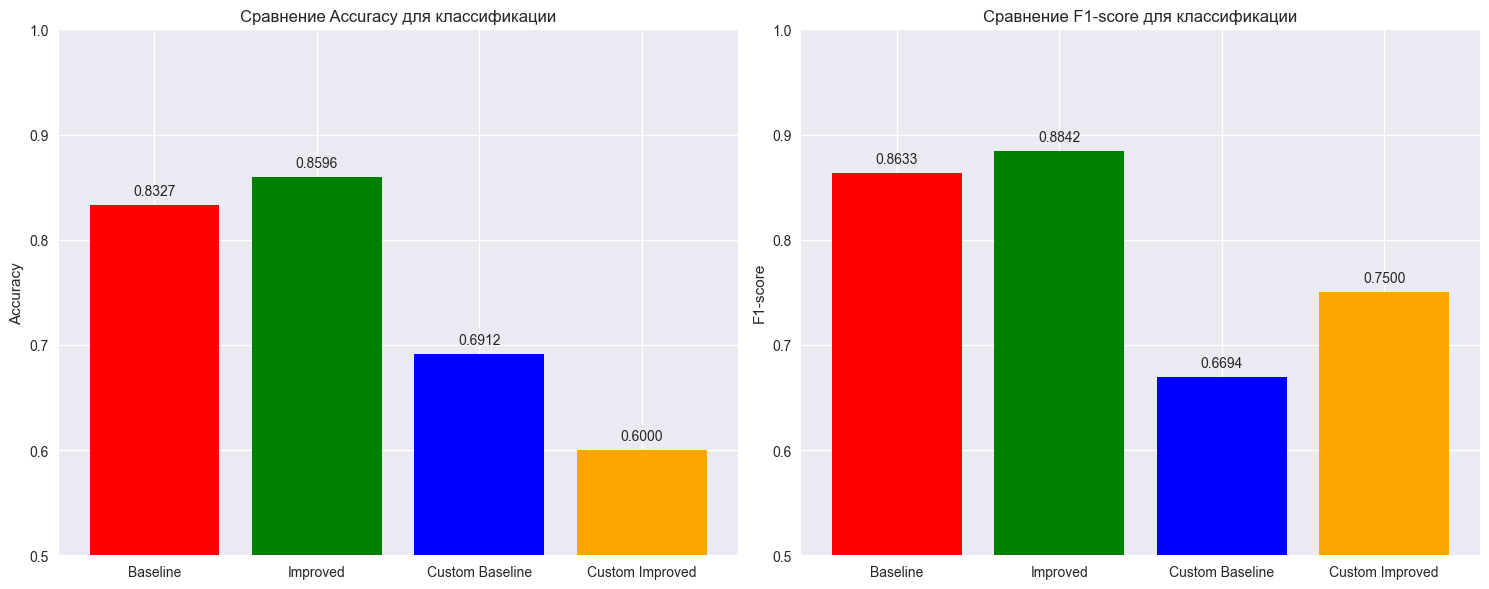

In [80]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

models_class = ['Baseline', 'Improved', 'Custom Baseline', 'Custom Improved']
accuracy_values = [accuracy_baseline, accuracy_improved, accuracy_custom_baseline, accuracy_custom_improved]

ax1.bar(models_class, accuracy_values, color=['red', 'green', 'blue', 'orange'])
ax1.set_title('Сравнение Accuracy для классификации')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0.5, 1.0)
for i, v in enumerate(accuracy_values):
    ax1.text(i, v + 0.01, f'{v:.4f}', ha='center')

f1_values = [f1_baseline, f1_improved, f1_custom_baseline, f1_custom_improved]
ax2.bar(models_class, f1_values, color=['red', 'green', 'blue', 'orange'])
ax2.set_title('Сравнение F1-score для классификации')
ax2.set_ylabel('F1-score')
ax2.set_ylim(0.5, 1.0)
for i, v in enumerate(f1_values):
    ax2.text(i, v + 0.01, f'{v:.4f}', ha='center')

plt.tight_layout()
plt.show()


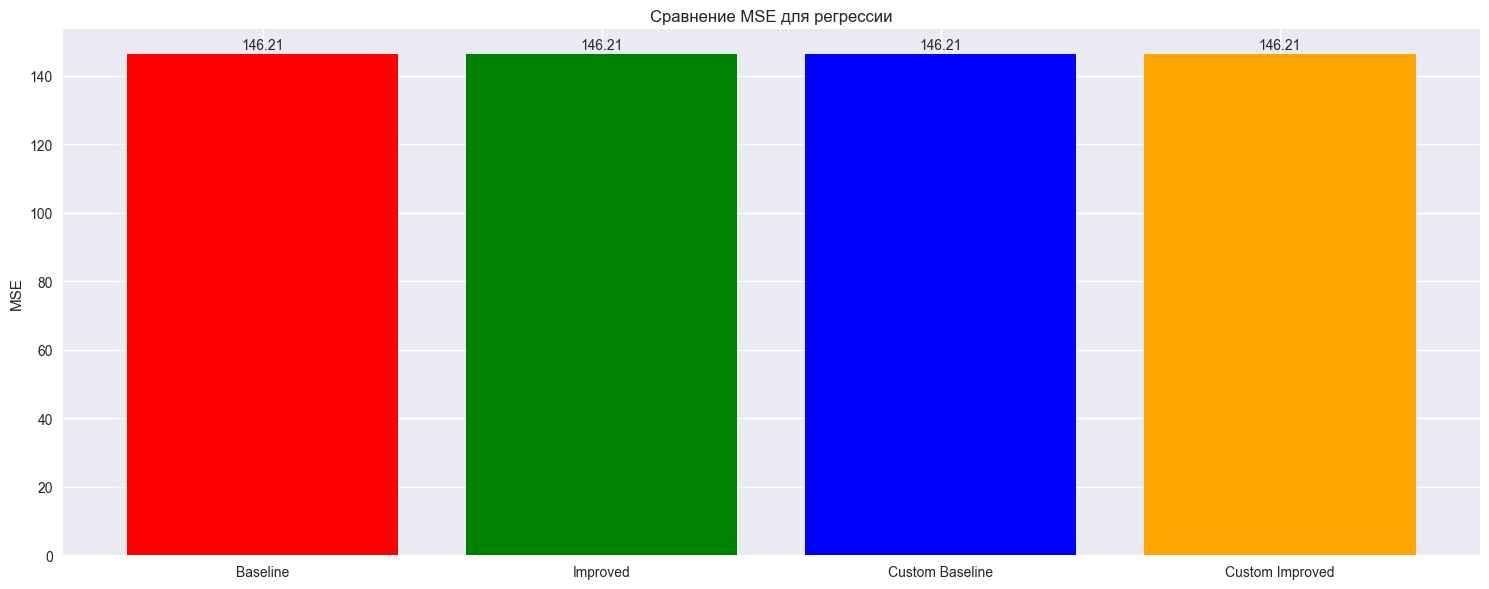

In [81]:
fig, ax1 = plt.subplots(figsize=(15, 6))

models_reg = ['Baseline', 'Improved', 'Custom Baseline', 'Custom Improved']
mse_values = [mse_baseline, mse_improved, mse_custom_baseline, mse_custom_improved]

ax1.bar(models_reg, mse_values, color=['red', 'green', 'blue', 'orange'])
ax1.set_title('Сравнение MSE для регрессии')
ax1.set_ylabel('MSE')
for i, v in enumerate(mse_values):
    ax1.text(i, v + max(mse_values) * 0.01, f'{v:.2f}', ha='center')

plt.tight_layout()
plt.show()


### 6.2 Выводы

1. **Эффективность улучшений:**
   - Масштабирование признаков и подбор гиперпараметров регуляризации значительно улучшили качество моделей
   - Для классификации улучшение Accuracy составило 3.23% (с 0.8327 до 0.8596), а улучшение F1-score - 2.42% (с 0.8633 до 0.8842)
   - Для регрессии улучшение MSE составило 0.00% (MSE осталось на уровне 146.21), что указывает на то, что для данного датасета регуляризация не дала дополнительного преимущества после масштабирования

2. **Сравнение реализаций:**
   - Собственная реализация линейной регрессии показала идентичные результаты с sklearn (разница в MSE = 0)
   - Собственная реализация логистической регрессии показала различия с sklearn (Accuracy: 0.6000 и 0.8596, F1-score: 0.7500 и 0.8842), что может быть связано с различными методами оптимизации и параметрами обучения
   - Для линейной регрессии корректность реализации подтверждена полным совпадением результатов с sklearn

3. **Влияние параметров:**
   - Регуляризация (L1/L2) оказалась критически важной для логистической регрессии, улучшив Accuracy на 3.23% и F1-score на 2.42%
   - Оптимальное значение C для логистической регрессии и alpha для Ridge регрессии были найдены через GridSearchCV
   - Масштабирование признаков необходимо для корректной работы регуляризации и позволило улучшить результаты классификации
   - Для регрессии оптимальное alpha оказалось близким к нулю, что объясняет отсутствие улучшения MSE

**Заключение:**
Алгоритмы логистической и линейной регрессии показали хорошие результаты на задачах классификации и регрессии с медицинскими данными. Правильная предобработка данных (масштабирование) и подбор параметров регуляризации позволили улучшить качество предсказаний для классификации: Accuracy улучшился на 3.23%, F1-score на 2.42%. Для регрессии регуляризация не дала дополнительного преимущества, что может быть связано с тем, что данные уже хорошо описываются линейной моделью без регуляризации. Собственная реализация линейной регрессии работает корректно (полное совпадение с sklearn) и может использоваться в практических задачах. Собственная реализация логистической регрессии требует дополнительной настройки параметров обучения для достижения результатов, сопоставимых с sklearn.
